# **Ocorrências Aeronáuticas**

## Informações Gerais

A base de dados de ocorrências aeronáuticas é gerenciada pelo Centro de Investigação e Prevenção de Acidentes Aeronáuticos (CENIPA). Constam nesta base de dados as ocorrências aeronáuticas notificadas ao CENIPA nos últimos 10 anos e que ocorreram em solo brasileiro. 

URL: https://dados.gov.br/dataset/ocorrencias-aeronauticas-da-aviacao-civil-brasileira

BASES DE DADOS UTILIZADAS:
*   OCORRÊNCIA.csv - Informações sobre as ocorrências.
*   AERONAVE.csv - Informações sobre as aeronaves envolvidas nas ocorrências.


## Identificação do problema a ser abordado

Cliente deseja saber se entre todas as ocorências notificadas (acidente, incidente leve, incidente grave), se é possivel prever a chance de um Acidente ocorrer.

## Importação dos pacotes necessários

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier 
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from xgboost import XGBClassifier
from xgboost import plot_importance
from sklearn.ensemble import VotingClassifier

from google.colab import files

In [2]:
#configurações para ajudar na visualização dos dados
np.set_printoptions(threshold=None, precision=2)
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)
pd.set_option('precision', 2)

##Leitura e análise da base principal

In [3]:
#carregando a base principal

uploaded = files.upload()
df_ocorrencias = pd.read_csv('ocorrencia_2010_2020.csv', sep=';')

Saving ocorrencia_2010_2020.csv to ocorrencia_2010_2020 (11).csv


In [4]:
#analise inicial da base

print("\nDimensões:\n{0}\n".format(df_ocorrencias.shape))
print("\nCampos:\n{0}\n".format(list(df_ocorrencias.keys())))
print("\nTipos dos dados:\n{0}\n".format(df_ocorrencias.info()))



Dimensões:
(5752, 22)


Campos:
['codigo_ocorrencia', 'codigo_ocorrencia1', 'codigo_ocorrencia2', 'codigo_ocorrencia3', 'codigo_ocorrencia4', 'ocorrencia_classificacao', 'ocorrencia_latitude', 'ocorrencia_longitude', 'ocorrencia_cidade', 'ocorrencia_uf', 'ocorrencia_pais', 'ocorrencia_aerodromo', 'ocorrencia_dia', 'ocorrencia_hora', 'investigacao_aeronave_liberada', 'investigacao_status', 'divulgacao_relatorio_numero', 'divulgacao_relatorio_publicado', 'divulgacao_dia_publicacao', 'total_recomendacoes', 'total_aeronaves_envolvidas', 'ocorrencia_saida_pista']

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5752 entries, 0 to 5751
Data columns (total 22 columns):
 #   Column                          Non-Null Count  Dtype 
---  ------                          --------------  ----- 
 0   codigo_ocorrencia               5752 non-null   int64 
 1   codigo_ocorrencia1              5752 non-null   int64 
 2   codigo_ocorrencia2              5752 non-null   int64 
 3   codigo_ocorrencia3   

In [5]:
#estatistica descritiva dos dados

print(df_ocorrencias.describe())
categ = df_ocorrencias.dtypes[df_ocorrencias.dtypes == "object"].index
print("\n", df_ocorrencias[categ].describe(), sep='\n')

       codigo_ocorrencia  codigo_ocorrencia1  codigo_ocorrencia2  \
count            5752.00             5752.00             5752.00   
mean            58504.21            58504.21            58504.21   
std             14060.29            14060.29            14060.29   
min             39115.00            39115.00            39115.00   
25%             46366.50            46366.50            46366.50   
50%             52692.50            52692.50            52692.50   
75%             77653.75            77653.75            77653.75   
max             79874.00            79874.00            79874.00   

       codigo_ocorrencia3  codigo_ocorrencia4  total_recomendacoes  \
count             5752.00             5752.00              5752.00   
mean             58504.21            58504.21                 0.30   
std              14060.29            14060.29                 1.15   
min              39115.00            39115.00                 0.00   
25%              46366.50            

##Tratamento inicial da base

Como o cliente deseja saber algo específico sobre o relacionamento entre tipo de aeronave e classificação da ocorrência, utlizaremos apenas algumas variáveis categóricas. Portanto, embora seja uma base muito rica em informações, para essa análise específica podem ser desconsiderados muitos atributos


In [6]:
#criando copia da base original utilizando apenas os atributos desejados

colunas = ['codigo_ocorrencia', 'ocorrencia_classificacao', 'ocorrencia_saida_pista']
df_ocorrencias = df_ocorrencias[colunas].copy() 

#Garantindo que não tenham ocorrências duplicadas

df_ocorrencias.sort_values(by=['codigo_ocorrencia'], ascending=[True],inplace=True)
df_ocorrencias.drop_duplicates(['codigo_ocorrencia'], keep='first', inplace=True)

## Enriquecimento da base trazendo informações sobre tipo e o modelo das aviações

In [7]:
#carregando a base aeronave já com as colunas escolhidas para analise

uploaded = files.upload()
df_aeronave = pd.read_csv('aeronave_2010_2020.csv', sep=';')
df_aeronave = df_aeronave[['codigo_ocorrencia2','aeronave_tipo_veiculo',
                           'aeronave_motor_tipo']]
df_aeronave = df_aeronave.rename(columns={'codigo_ocorrencia2': 'codigo_ocorrencia'})
df_aeronave.sort_values(by=['codigo_ocorrencia'], ascending=[True],inplace=True)
df_aeronave.drop_duplicates(['codigo_ocorrencia'], keep='first', inplace=True)

# merge ocorrencias e aeronave
df_ocorrencias = pd.merge(
    df_ocorrencias,
    df_aeronave,
    how='left',
    on='codigo_ocorrencia'
)

Saving aeronave_2010_2020.csv to aeronave_2010_2020 (11).csv


##Preparando os dados para o modelo

In [8]:
df_ocorrencias.head(5)

,codigo_ocorrencia,ocorrencia_classificacao,ocorrencia_saida_pista,aeronave_tipo_veiculo,aeronave_motor_tipo
0,39115,ACIDENTE,NÃO,AVIÃO,PISTÃO
1,39155,INCIDENTE,NÃO,AVIÃO,TURBOÉLICE
2,39156,INCIDENTE GRAVE,NÃO,AVIÃO,TURBOÉLICE
3,39158,INCIDENTE,NÃO,AVIÃO,JATO
4,39176,INCIDENTE,NÃO,AVIÃO,JATO


In [9]:
#tratando os valores que estavam faltando "***"" e passando para "NÃO INFORMADO"
df_ocorrencias['aeronave_tipo_veiculo'] = df_ocorrencias['aeronave_tipo_veiculo'].replace({'***':'NÃO INFORMADO'})
df_ocorrencias['aeronave_motor_tipo'] = df_ocorrencias['aeronave_motor_tipo'].replace({'***':'NÃO INFORMADO'})

#Criando coluna acidente a partir da ocorrencia_classificacao com os valores SIM ou NÃO para predição
conditions = [
        (df_ocorrencias['ocorrencia_classificacao'].str.contains('ACIDENTE')),
        (df_ocorrencias['ocorrencia_classificacao'].str.contains('INCIDENTE'))]

values = ['SIM','NÃO']

df_ocorrencias['acidente'] = np.select(conditions, values).copy()

#limpando  o df
del df_ocorrencias["codigo_ocorrencia"]
del df_ocorrencias["ocorrencia_classificacao"]

In [10]:
df_ocorrencias

,ocorrencia_saida_pista,aeronave_tipo_veiculo,aeronave_motor_tipo,acidente
0,NÃO,AVIÃO,PISTÃO,SIM
1,NÃO,AVIÃO,TURBOÉLICE,NÃO
2,NÃO,AVIÃO,TURBOÉLICE,NÃO
3,NÃO,AVIÃO,JATO,NÃO
4,NÃO,AVIÃO,JATO,NÃO
...,...,...,...,...
5747,NÃO,AVIÃO,JATO,NÃO
5748,NÃO,NÃO INFORMADO,JATO,NÃO
5749,NÃO,AVIÃO,PISTÃO,SIM
5750,NÃO,HELICÓPTERO,TURBOEIXO,NÃO


## Preparação

Criando variáveis independentes e dependentes

In [11]:
y = df_ocorrencias['acidente']
X = df_ocorrencias
X = df_ocorrencias.drop('acidente',axis = 1)

In [12]:
#Tratando a variavel categorica alterando valor para binário 0 e 1
le = LabelEncoder()
X['ocorrencia_saida_pista'] = le.fit_transform(X['ocorrencia_saida_pista']) 
X.head(10)

,ocorrencia_saida_pista,aeronave_tipo_veiculo,aeronave_motor_tipo
0,0,AVIÃO,PISTÃO
1,0,AVIÃO,TURBOÉLICE
2,0,AVIÃO,TURBOÉLICE
3,0,AVIÃO,JATO
4,0,AVIÃO,JATO
5,0,AVIÃO,JATO
6,0,AVIÃO,PISTÃO
7,0,HELICÓPTERO,TURBOEIXO
8,0,ULTRALEVE,PISTÃO
9,0,HELICÓPTERO,TURBOEIXO


In [13]:
#Tratando as variáveis que possuem mais de dois tipos:
x_final = pd.get_dummies (data = X, columns = ['aeronave_tipo_veiculo','aeronave_motor_tipo'] )
x_final

,ocorrencia_saida_pista,aeronave_tipo_veiculo_ANFÍBIO,aeronave_tipo_veiculo_AVIÃO,aeronave_tipo_veiculo_BALÃO,aeronave_tipo_veiculo_DIRIGÍVEL,aeronave_tipo_veiculo_HELICÓPTERO,aeronave_tipo_veiculo_HIDROAVIÃO,aeronave_tipo_veiculo_NÃO INFORMADO,aeronave_tipo_veiculo_PLANADOR,aeronave_tipo_veiculo_TRIKE,aeronave_tipo_veiculo_ULTRALEVE,aeronave_motor_tipo_JATO,aeronave_motor_tipo_NÃO INFORMADO,aeronave_motor_tipo_PISTÃO,aeronave_motor_tipo_SEM TRAÇÃO,aeronave_motor_tipo_TURBOEIXO,aeronave_motor_tipo_TURBOÉLICE
0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0
1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0
4,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5747,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0
5748,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0
5749,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0
5750,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0


In [14]:
# Separando em dados teste e treinamento 
x_treino, x_teste, y_treino, y_teste  = train_test_split(x_final, y, test_size = 0.25, random_state = 1)

## Modelo KNN

In [15]:
#configurando o modelo
knn = KNeighborsClassifier()
knn.fit(x_treino, y_treino)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [16]:
#matriz de confusão
resultado_knn = knn.predict(x_teste)
print (pd.crosstab(y_teste, resultado_knn, rownames = ['Real'], colnames = ['Predito'], margins = True))

Predito  NÃO  SIM   All
Real                   
NÃO      560  428   988
SIM      113  337   450
All      673  765  1438


Text(0, 0.5, 'Erro Médio')

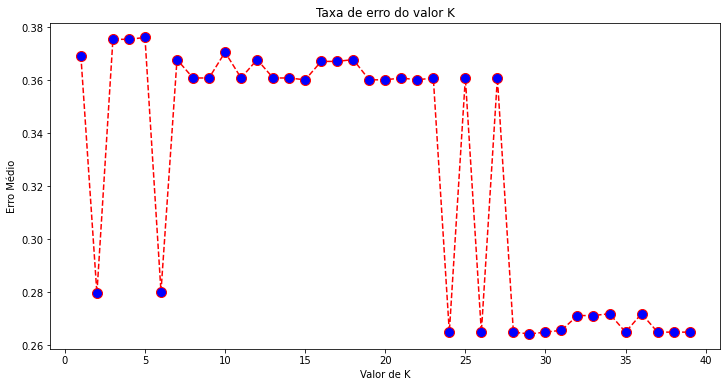

In [17]:
#encontrando o melhor K para valores entre 1 e 40
error = []

for i in range(1, 40):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(x_treino, y_treino)
    pred_i = knn.predict(x_teste)
    error.append(np.mean(pred_i != y_teste))

plt.figure(figsize=(12, 6))
plt.plot(range(1, 40), error, color='red', linestyle='dashed', marker='o',
         markerfacecolor='blue', markersize=10)
plt.title('Taxa de erro do valor K')
plt.xlabel('Valor de K')
plt.ylabel('Erro Médio')



Observando o gráfico é possivel ver que o K=29 apresentou o menor erro médio

In [18]:
#Utiliznado o K encontrado:
knn = KNeighborsClassifier(n_neighbors=29)
knn.fit(x_treino, y_treino)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=29, p=2,
                     weights='uniform')

In [19]:
resultado_knn = knn.predict(x_teste)
print (pd.crosstab(y_teste,resultado_knn, rownames=['Real'], colnames=['Predito'], margins=True))

Predito   NÃO  SIM   All
Real                    
NÃO       911   77   988
SIM       303  147   450
All      1214  224  1438


## Modelo Random Forest

In [20]:
# Treinando o modelo
rf = RandomForestClassifier (n_estimators = 1000, random_state = 42)  
rf.fit (x_treino, y_treino); 

In [21]:
y_rf = rf.predict(x_teste)
print(pd.crosstab(y_teste,y_rf, rownames=['Real'], colnames=['Predito'], margins=True))
print('\n')
print(classification_report(y_teste, y_rf))

Predito   NÃO  SIM   All
Real                    
NÃO       916   72   988
SIM       306  144   450
All      1222  216  1438


              precision    recall  f1-score   support

         NÃO       0.75      0.93      0.83       988
         SIM       0.67      0.32      0.43       450

    accuracy                           0.74      1438
   macro avg       0.71      0.62      0.63      1438
weighted avg       0.72      0.74      0.70      1438



O modelo de Random Forest conseguiu melhores resultados, porém ainda com  bastante falsos negativos.Tentar um modelo mais robusto e que não sofre tanta influência em amostras desbalanceadas

In [22]:
#Analisando a importância de cada variável
pd.set_option('display.float_format', lambda x: '%.3f' % x) #configurando pandas para mostrar valor inteiro ao inves notação cientifica
rf.feature_importances_

feature_importances = pd.DataFrame(rf.feature_importances_, index = x_treino.columns, columns=['importância']).sort_values('importância',ascending=False)
feature_importances

,importância
aeronave_motor_tipo_PISTÃO,0.378
aeronave_motor_tipo_JATO,0.216
aeronave_tipo_veiculo_ULTRALEVE,0.082
aeronave_tipo_veiculo_AVIÃO,0.081
ocorrencia_saida_pista,0.071
aeronave_motor_tipo_TURBOÉLICE,0.052
aeronave_motor_tipo_TURBOEIXO,0.039
aeronave_tipo_veiculo_HELICÓPTERO,0.030
aeronave_motor_tipo_NÃO INFORMADO,0.019
aeronave_tipo_veiculo_NÃO INFORMADO,0.009


## Modelo XGBoost

In [23]:
# ajuste do modelo
xgb = XGBClassifier(learning_rate =0.1,
 n_estimators=1000,
 max_depth=6,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1.0,
 seed=27)
xgb.fit(x_treino, y_treino)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
              nthread=4, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1.0, seed=27,
              silent=None, subsample=0.8, verbosity=1)

In [24]:
#fazendo as predições no dados de teste
preditos_xgb = xgb.predict(x_teste)
print (pd.crosstab(y_teste,preditos_xgb, rownames=['Real'], colnames=['Predito'], margins=True))

Predito   NÃO  SIM   All
Real                    
NÃO       912   76   988
SIM       303  147   450
All      1215  223  1438


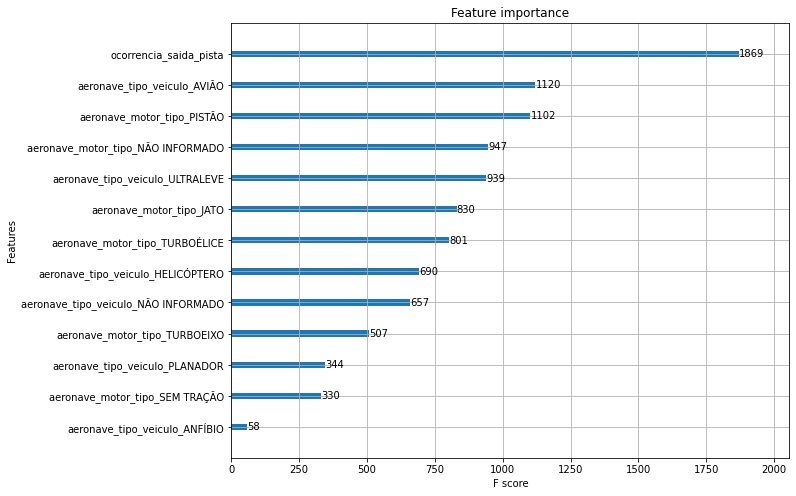

In [25]:
#Analisando a importância de cada variável
#from xgboost import plot_importance
fig, ax = plt.subplots(figsize=(10,8))
plot_importance(xgb, ax=ax)

## Métodos Ensemble: combinando os dois melhores modelos, Random Forest e XGBoost.

In [26]:
# Voting Classifier with soft voting 
voto = VotingClassifier(estimators=[('rf', rf),('xgb',xgb)], voting='soft')
voto = voto.fit(x_treino,y_treino)

y_predito = voto.predict(x_teste)
print(pd.crosstab(y_teste,y_predito, rownames=['Real'], colnames=['Predito'], margins=True))
print('\n')
print(classification_report(y_teste, y_predito))

Predito   NÃO  SIM   All
Real                    
NÃO       912   76   988
SIM       302  148   450
All      1214  224  1438


              precision    recall  f1-score   support

         NÃO       0.75      0.92      0.83       988
         SIM       0.66      0.33      0.44       450

    accuracy                           0.74      1438
   macro avg       0.71      0.63      0.63      1438
weighted avg       0.72      0.74      0.71      1438



Levando a probabilidade de volta para o df

In [27]:
df_ocorrencias['probabilidade'] = voto.predict_proba(x_final[x_treino.columns])[:,1]
df_ocorrencias

,ocorrencia_saida_pista,aeronave_tipo_veiculo,aeronave_motor_tipo,acidente,probabilidade
0,NÃO,AVIÃO,PISTÃO,SIM,0.409
1,NÃO,AVIÃO,TURBOÉLICE,NÃO,0.144
2,NÃO,AVIÃO,TURBOÉLICE,NÃO,0.144
3,NÃO,AVIÃO,JATO,NÃO,0.015
4,NÃO,AVIÃO,JATO,NÃO,0.015
...,...,...,...,...,...
5747,NÃO,AVIÃO,JATO,NÃO,0.015
5748,NÃO,NÃO INFORMADO,JATO,NÃO,0.006
5749,NÃO,AVIÃO,PISTÃO,SIM,0.409
5750,NÃO,HELICÓPTERO,TURBOEIXO,NÃO,0.227


## Tratando DF final

In [28]:
df_final = df_ocorrencias[['aeronave_tipo_veiculo','aeronave_motor_tipo','ocorrencia_saida_pista','probabilidade']].copy()
df_final.sort_values(by=['probabilidade','aeronave_tipo_veiculo','aeronave_motor_tipo'], ascending=[False,True,True],inplace=True)
df_final.drop_duplicates(['probabilidade','aeronave_tipo_veiculo','aeronave_motor_tipo'], keep='first', inplace=True)
df_final = df_final.rename(columns={'aeronave_tipo_veiculo': 'Tipo de Veículo', 'aeronave_motor_tipo': 'Tipo de Motor',
                                    'ocorrencia_saida_pista':'Acidente na saída de pista', 'probabilidade':'Probabilidade de ser Acidente'})

#remove as linhas que tipo de veiculo nao foi informado
df_final = df_final[~df_final['Tipo de Veículo'].str.contains('NÃO INFORMADO')]

df_final.reset_index(drop=True, inplace=True)



In [29]:
df_final

,Tipo de Veículo,Tipo de Motor,Acidente na saída de pista,Probabilidade de ser Acidente
0,TRIKE,NÃO INFORMADO,NÃO,0.985
1,PLANADOR,NÃO INFORMADO,NÃO,0.902
2,PLANADOR,SEM TRAÇÃO,SIM,0.901
3,AVIÃO,NÃO INFORMADO,SIM,0.895
4,BALÃO,SEM TRAÇÃO,NÃO,0.893
5,HELICÓPTERO,PISTÃO,NÃO,0.747
6,ANFÍBIO,TURBOÉLICE,NÃO,0.717
7,ULTRALEVE,PISTÃO,NÃO,0.716
8,ULTRALEVE,NÃO INFORMADO,NÃO,0.626
9,PLANADOR,SEM TRAÇÃO,NÃO,0.597
